In [1]:
import numpy as np #for numerical operations
import pandas as pd #for data manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns #for advance visualizations
from sklearn.preprocessing import MinMaxScaler , StandardScaler #for feature scaling
from sklearn.feature_selection import SelectKBest ,f_regression
from sklearn.model_selection import train_test_split #for splitting data
from sklearn.model_selection import GridSearchCV #for hyperparameter tuning
from sklearn.neighbors import KNeighborsRegressor#for KNN regression 
from xgboost import XGBRegressor #for xgboost regression
from sklearn.ensemble import RandomForestRegressor # for Random Forest Regression
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.metrics import mean_absolute_error,mean_squared_error , r2_score #for evaluation metrics

In [2]:
data = pd.read_csv('stock_data.csv')
data.head()

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [3]:
df = pd.DataFrame(data)
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [4]:
#convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.isnull().sum() #checking for null values

date       0
Stock_1    0
Stock_2    0
Stock_3    0
Stock_4    0
Stock_5    0
dtype: int64

In [6]:
 #Extracting features from date column
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek

In [7]:
df.drop(columns= ['date'],inplace=True)

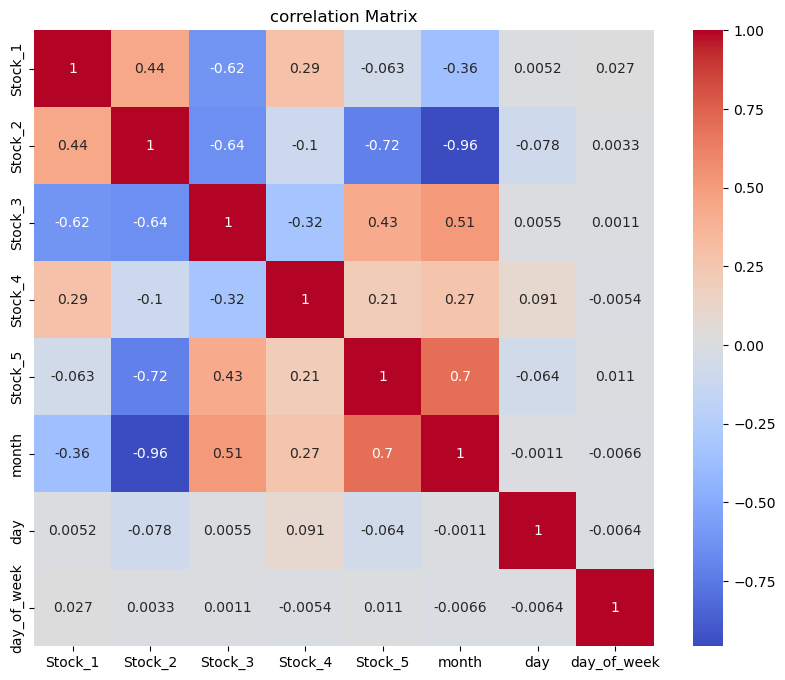

In [8]:
cormap = df.corr()#correlation analysis
plt.figure(figsize=(10,8))
sns.heatmap(cormap, annot = True,cmap='coolwarm')
plt.title('correlation Matrix')
plt.show()

In [9]:
#select features with high correlation to the target variable
def get_correlated_features(cor_data, threshold):
    feature = []
    value = []
    for index in cor_data.index:
        if abs(cor_data[index])>threshold and index != 'Stock_2':
            feature.append(index)
            value.append(cor_data[index])
    return pd.DataFrame(data = value, index=feature, columns=['Correlation'])

In [10]:
correlated_features = get_correlated_features(cormap['Stock_2'],0.3)
selected_features = correlated_features.index.tolist()

In [11]:
#target variable and feature selection
X = df[selected_features]
y = df['Stock_2']

In [12]:
scalar = StandardScaler()#feature scaling using Standard scalar
X_scaled = scalar.fit_transform(X)

In [13]:
#feature scaling using SelectKBest
k_best = SelectKBest(score_func=f_regression,k ='all')
X_selected = k_best.fit_transform(X_scaled , y )
selected_feature_names = X.columns[k_best.get_support()]
X = pd.DataFrame(X_selected,columns=selected_feature_names)

In [14]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#function to evaluate models
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE:{mse},RMSE:{rmse},MAE:{mae},R2:{r2}")

In [16]:
#Random Forest with optimized hyperparameters
rf_param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [10,20,None],
    'min_samples_split' : [2,5,10]
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
rf.fit(X_train, y_train)
print('Best RF Parameters:',rf.best_params_)
print("Random Forest Performance:")
evaluate_model(rf.best_estimator_, X_test, y_test)

Best RF Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Performance:
MSE:2.1276167275784745,RMSE:1.4586352277312085,MAE:1.1135956567905063,R2:0.9855841136207973


In [17]:
#XGBoost with optimized hyperparameters
xgb_param_grid = {
    'n_estimators' : [100,200],
    'learning_rate' : [0.01, 0.1],
    'max_depth' : [3, 6]
}
xgb = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=3, n_jobs=-1)
xgb.fit(X_train, y_train)
print('Best XGBoost Parameters:',xgb.best_params_)
print("XGBoost Performance:")
evaluate_model(xgb.best_estimator_, X_test, y_test)

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost Performance:
MSE:2.8536387189534125,RMSE:1.6892716533919026,MAE:1.2593232548608175,R2:0.9806648768048809


In [18]:
#linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression Performance:")
evaluate_model(lr, X_test, y_test)

Linear Regression Performance:
MSE:7.501377419693546,RMSE:2.7388642572594843,MAE:2.234976530312684,R2:0.949173644309097


In [19]:
# KNN with optimized hyperparameters
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5)
knn.fit(X_train, y_train)
print("Best KNN Parameters:", knn.best_params_)
print("KNN Model Performance:")
evaluate_model(knn.best_estimator_, X_test, y_test)

Best KNN Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
KNN Model Performance:
MSE:2.0462353418136203,RMSE:1.430466826533779,MAE:1.0854463057100945,R2:0.986135521586039


In [20]:
import joblib
best_model = knn.best_estimator_  # Save the actual best-performing model (KNN)
joblib.dump(best_model, "best_model.pkl")
print("Best model saved as 'best_model.pkl'")

Best model saved as 'best_model.pkl'


In [21]:
# Deployment placeholder
print("Model is ready for deployment. Load 'best_model.pkl' in your deployment environment for predictions.")


Model is ready for deployment. Load 'best_model.pkl' in your deployment environment for predictions.
